# Using PyTorch and MONAI for MRI Alzheimer's Classification

In [1]:
import logging
import os
import sys
from tqdm.notebook import tqdm
import nibabel.freesurfer.mghformat as mgh

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ImageDataset, decollate_batch
from monai.metrics import ROCAUCMetric
from monai.transforms import Activations, AsDiscrete, AddChannel, Compose, Resize, ScaleIntensity, EnsureType, SpatialCrop

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

MONAI version: 0.6.0
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.61.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.3.0
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# This class allows you to access dictionary items with a dot
# Gathered from here: https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

FLAGS = {
    'shape'       : (128, 128, 128),
    'data_dir'    : '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data',  # use this if on jupyter
    'batch_size'  : 5,
    'random_state': 124,
    'epochs'      : 110
}
FLAGS = dotdict(FLAGS)
print(FLAGS)

{'shape': (128, 128, 128), 'data_dir': '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data', 'batch_size': 5, 'random_state': 124, 'epochs': 110}


In [3]:
from sklearn.utils import shuffle

def generate_filenames(labels=['control', 'dementia']):
    pairs = []
    
    for label in labels:
        label_dir = os.path.join(FLAGS.data_dir, label)
        mr_ids = os.listdir(label_dir)
        mr_ids.sort()
        
        for mr_id in tqdm(mr_ids, desc=label):
            scans = os.path.join(label_dir, mr_id)
            img_file = [file for file in os.listdir(scans) if "nii.gz" in file]
            img_path = os.path.join(scans, img_file[0])
            i = 1 if label == 'dementia' else 0
            pairs.append([img_path, i])
    
    m = len(pairs)
    filenames = []
    labels = np.zeros(m, dtype=np.int64)
    
    idx = 0
    for filename, label in pairs:
        filenames.append(filename)
        labels[idx] = label
        idx += 1
    
    filenames = np.array(filenames)
    filenames, labels = shuffle(filenames, labels, random_state=FLAGS.random_state)
    return filenames, labels
        

X_filenames, y_labels = generate_filenames()

control:   0%|          | 0/712 [00:00<?, ?it/s]

dementia:   0%|          | 0/310 [00:00<?, ?it/s]

In [4]:
# There are two labels: 0 represents control patients, and 1 represents dementia patients
for idx in range(len(X_filenames)):
    if idx < 10:
        print(y_labels[idx], X_filenames[idx])
    dementia = "dementia" in X_filenames[idx]
    label = y_labels[idx]
    if int(dementia) != label:
        print("Bad: ", X_filenames[idx], label)

0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30233_MR_d3867/OAS30233.nii.gz
1 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30311_MR_d0127/OAS30311.nii.gz
1 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30326_MR_d0189/OAS30326.nii.gz
1 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS31038_MR_d4037/OAS31038.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30565_MR_d3127/OAS30565.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30780_MR_d1044/OAS30780.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30652_MR_d0778/OAS30652.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS31066_MR_d0077/OAS31066.nii.gz
0 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30857_MR_d0058/OAS30857.nii.gz
1 /home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30530_MR_d0119/OAS30530.nii.gz


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filenames, y_labels, test_size=.25, random_state=FLAGS.random_state, shuffle=True)

In [6]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(766,) (256,) (766,) (256,)


In [7]:
train_files = [{"img": img, "label": label} for img, label in zip(X_train, y_train)]
val_files = [{"img": img, "label": label} for img, label in zip(X_test, y_test)]

In [8]:
# Validate the train and val sets
for image in train_files:
    dementia = "dementia" in image["img"]
    label = image["label"]
    if int(dementia) != label:
        print("Bad: ", image)

for image in val_files:
    dementia = "dementia" in image["img"]
    label = image["label"]
    if int(dementia) != label:
        print("Bad: ", image)
        
print(len(train_files), len(val_files))

766 256


In [9]:
# define transforms
transforms = Compose([ScaleIntensity(), AddChannel(), Resize(FLAGS.shape), SpatialCrop(roi_start=(15, 15, 0), roi_end=(110,110,110)), EnsureType()])

In [10]:
# Define image dataset, data loader
check_ds = ImageDataset(image_files=X_filenames, labels=y_labels, transform=transforms)
check_loader = DataLoader(check_ds, batch_size=FLAGS.batch_size, num_workers=12, pin_memory=torch.cuda.is_available())
im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label)

<class 'torch.Tensor'> torch.Size([5, 1, 95, 95, 110]) tensor([0, 1, 1, 1, 0])


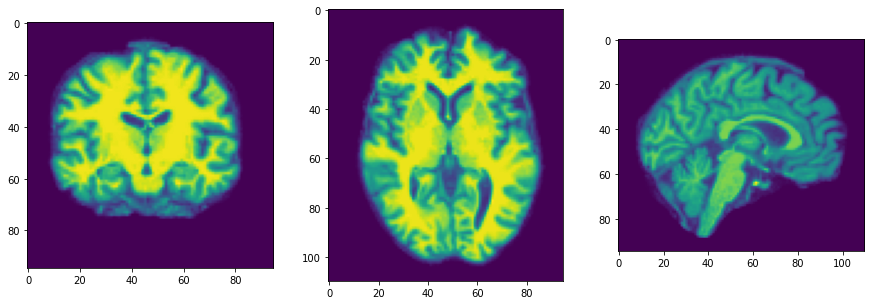

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(np.rot90(im[0, 0, :, :, int(110/2)], 3))
ax[1].imshow(np.rot90(im[0, 0, :, int(95/2), :]))
ax[2].imshow(im[0, 0, int(95/2), :, :])

In [12]:
from IPython import display as dspl
import ipywidgets as widgets

# graphs the MRI image
def show_graph(img, height, width, depth, color, patient):
    # Plots brain scans in all three dimensions
    fig, ax = plt.subplots(1, 3, figsize=(15,7))
    pat_types = ['control', 'dementia']
    print(pat_types[label[patient]])
    print(img.shape)

    ax[0].set_title("height")
    ax[1].set_title("width")
    ax[2].set_title("depth")

    colormap = 'gray' if color == 'Gray' else 'viridis'
    ax[0].imshow(img[patient, 0, height, :, :], cmap=colormap)
    ax[1].imshow(np.rot90(img[patient, 0, :, width, :]), cmap=colormap)
    ax[2].imshow(np.rot90(img[patient, 0, :, :, depth], 3), cmap=colormap)
    

def disp(pat_type, image_data):
    num_pats, _, height, width, depth  = image_data.shape
    co = widgets.ToggleButtons(options=['Gray', 'Color'], description='Color Map')
    hi = widgets.IntSlider(value=height/2, max=height-1, continous_updates=False, description='View 1')
    wi = widgets.IntSlider(value=width/2, max=width-1, continous_updates=False, description='View 2')
    de = widgets.IntSlider(value=depth/2, max=depth-1, continous_updates=False, description='View 3')
    pat = widgets.Dropdown(options=range(num_pats), value=0, description='Patient Number')
    ui = widgets.HBox([hi, wi, de, co, pat])
    
    display_output = widgets.interactive_output(show_graph, {'img':widgets.fixed(image_data),
                                                             'height':hi,
                                                             'width':wi,
                                                             'depth':de,
                                                             'color':co,
                                                             'patient':pat})
    dspl.display(ui, display_output)

disp(label[0], im)

Output()

In [13]:
# create a training data loader
train_ds = ImageDataset(image_files=X_train, labels=y_train, transform=transforms)
train_loader = DataLoader(train_ds, batch_size=FLAGS.batch_size, shuffle=True, num_workers=12, pin_memory=torch.cuda.is_available())

# create a validation data loader
val_ds = ImageDataset(image_files=X_test, labels=y_test, transform=transforms)
val_loader = DataLoader(val_ds, batch_size=FLAGS.batch_size, num_workers=12, pin_memory=torch.cuda.is_available())

In [14]:
# Create DenseNet121, CrossEntropyLoss and SGD optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2, dropout_prob=0.7).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=False)

In [15]:
auc_metric = ROCAUCMetric()
post_pred = Compose([EnsureType(), Activations(softmax=True)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

In [16]:
def lr_scheduler(optimizer, epoch, lr_decay=0.1, lr_decay_epochs=[]):
    """Decay learning rate by lr_decay on predefined epochs"""
    if epoch not in lr_decay_epochs:
        return optimizer
    
    print('Learning rate decay of {} on epoch {}.'.format(lr_decay, epoch))
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay

    return optimizer

Epochs:   0%|          | 0/110 [00:00<?, ?it/s]

----------
epoch 1/110
current lr: 0.1


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 1 average loss: 5.0024
----------
epoch 2/110
current lr: 0.1


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 2 average loss: 1.0748
saved new best metric model52
current epoch: 2 current accuracy: 0.6797 current AUC: 0.5814 best accuracy: 0.6797 at epoch 2


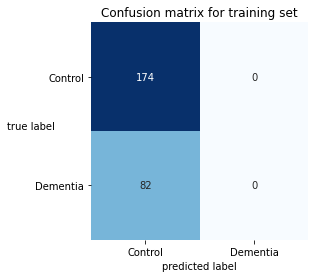

----------
epoch 3/110
current lr: 0.1


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 3 average loss: 0.6641
----------
epoch 4/110
current lr: 0.1


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 4 average loss: 0.6519
current epoch: 4 current accuracy: 0.6680 current AUC: 0.4578 best accuracy: 0.6797 at epoch 2


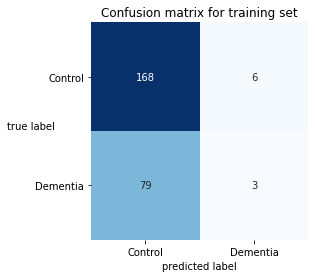

----------
epoch 5/110
current lr: 0.1


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 5 average loss: 0.6495
----------
epoch 6/110
current lr: 0.1


  0%|          | 0/154 [00:00<?, ?it/s]

epoch 6 average loss: 0.6308
current epoch: 6 current accuracy: 0.6797 current AUC: 0.5837 best accuracy: 0.6797 at epoch 2


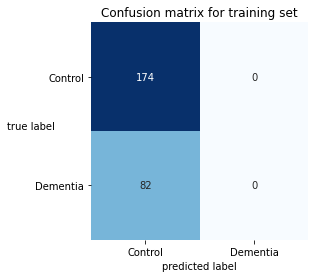

----------
epoch 7/110
current lr: 0.1


  0%|          | 0/154 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
n_epochs = FLAGS.epochs

for epoch in tqdm(range(n_epochs), desc='Epochs'):
    lr_scheduler(optimizer, epoch, lr_decay=0.1, lr_decay_epochs=[80])
    
    print("-" * 10)
    print(f"epoch {epoch + 1}/{n_epochs}")
    curr_lr = optimizer.state_dict()['param_groups'][0]['lr']
    print(f'current lr: {curr_lr}')
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in tqdm(train_loader, file=sys.stdout):
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}", end='\r')
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            # Loop through validation data and get predictions
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for iteration, val_data in enumerate(val_loader):
                print(f'Reading validation set: {iteration}/{len(val_loader)}', end='\r')
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            
            # Calculate metrics
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            y_onehot = [post_label(i) for i in decollate_batch(y)]
            y_pred_act = [post_pred(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            
            # Check if accuracy is better
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_classification3d_dict.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current accuracy: {:.4f} current AUC: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                    epoch + 1, acc_metric, auc_result, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)
            
            # Create a confusion matrix
            predictions = y_pred.argmax(dim=1).cpu().numpy()
            y_res = y.cpu().numpy()
            mat = confusion_matrix(y_res, predictions)
            sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['Control', 'Dementia'],
            yticklabels=['Control', 'Dementia'])
            plt.xlabel('predicted label')
            plt.ylabel('true label', rotation=0)
            plt.yticks(rotation=0)
            plt.title('Confusion matrix for training set')
            plt.show()
            del y_res, predictions


print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()